## Résultats et Interprétations

Dans cette section, nous analysons les performances des différents modèles testés après le pré-processing des features.
Au moyen de plusieurs étapes d’ajustement, de filtrage et de comparaison, nous cherchons à identifier les modèles les plus équilibrés, c’est-à-dire ceux offrant :

 - un bon compromis entre score train et test,
 - un écart (gap) faible,
 - une stabilité selon la taille des images et le nombre d’échantillons,
 - un temps de calcul raisonnable.

L’objectif final est de sélectionner les modèles les plus adaptés pour réaliser la prédiction des images COVID sur notre jeu de données.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [13]:
df=pd.read_csv("resultats_modeles_final.csv")
df.head()

,Type,sample,taille,clf,score_train,score_test,Temps(s)
0,Classique,1664,64,SVC,0.9279,0.7216,1.84
1,Classique,1664,64,KNN,0.7314,0.6136,0.00
2,Classique,1664,64,MLP,1.0000,0.7050,2.09
3,Classique,1664,64,LR,1.0000,0.6127,0.44
4,Classique,1664,128,SVC,0.9297,0.7147,2.69


In [22]:
#Une description de notre jeu de données.
df.describe()

,sample,taille,score_train,score_test,Temps(s)
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,4864.000000,178.200000,0.952690,0.679939,234.786444
std,2566.960404,80.499445,0.082595,0.073535,825.015756
min,1664.000000,64.000000,0.718100,0.463500,0.000000
25%,2664.000000,128.000000,0.924200,0.654700,1.030000
50%,4664.000000,176.000000,1.000000,0.697100,8.130000
75%,6664.000000,224.000000,1.000000,0.729900,54.490000
max,8664.000000,299.000000,1.000000,0.795900,8674.880000


Les statistiques montrent que certains modèles atteignent un score d’entraînement parfait (1.0), signe qu’ils apprennent entièrement les données d’entraînement. Cependant, la distribution révèle également que 25 % des modèles affichent un score_train inférieur ou égal à 0.924, ce qui souligne une hétérogénéité notable dans la capacité d’apprentissage selon les configurations testées.

Concernant les performances en test, la médiane du score_test est d’environ 0.697, ce qui signifie que la moitié des modèles obtiennent un score inférieur à 0.70. Autrement dit, près de 50 % des modèles se trouvent en situation de sous-apprentissage, puisqu’ils n’arrivent pas à généraliser correctement sur les données de test, malgré des performances parfois très élevées en entraînement.

---


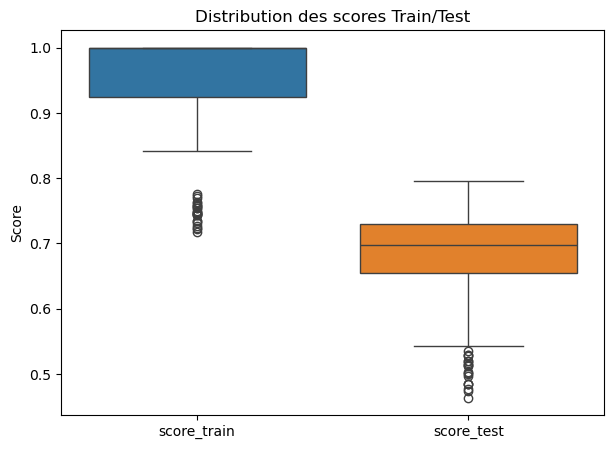

In [15]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df[['score_train', 'score_test']])
plt.title("Distribution des scores Train/Test")
plt.ylabel("Score")
plt.show()

Analyse préliminaire des performances (Boxplot)

Comme on peut l’observer sur les boxplots des scores d’entraînement et de test, il existe une forte disparité entre les deux distributions.
On remarque également la présence de nombreuses valeurs très basses, ce qui tire la moyenne générale vers le bas lorsque l’on considère l’ensemble des modèles testés.

Cette variation importante laisse supposer qu’il existe, parmi nos modèles :

- des modèles équilibrés, ayant un écart faible entre train et test,
- des modèles en sous-apprentissage (scores faibles en train comme en test),
- des modèles en sur-apprentissage (score train très élevé mais score test nettement plus faible).

Dans la suite du notebook, nous allons donc examiner en détail chaque configuration afin d’identifier précisément :

 - quels modèles sont les plus stables,
 - lesquels sont en sous-apprentissage,
 - lesquels sont en sur-apprentissage.

---


In [57]:
gap = df["score_train"] - df["score_test"]
df_resume=df.groupby(["clf"]).agg({"score_train":"mean","score_test":"mean","Temps(s)":"mean"}).copy()
df_resume["gap"]=df_resume["score_train"] - df_resume["score_test"]
df_resume

df_resume["interpretation"] = "Equilibré"
df_resume.loc[(df_resume["score_train"] > df_resume["score_test"]) & (df_resume["gap"] > 0.27),"interpretation"] = "Sur-apprentissage"
df_resume.loc[(df_resume["score_train"] < 0.8) & (df_resume["score_test"] < 0.8),"interpretation"] = "Sous-apprentissage"
df_resume.head()


,score_train,score_test,Temps(s),gap,interpretation
clf,,,,,
DecisionTree,1.000000,0.514604,22.1452,0.485396,Surapprentissage
ExtraTrees,1.000000,0.695844,1.9712,0.304156,Surapprentissage
GradientBoosting,0.915268,0.710836,1640.7248,0.204432,Equilibré
KNN,0.747336,0.623692,0.0144,0.123644,Sous-apprentissage
LR,0.993328,0.667204,3.8416,0.326124,Surapprentissage


Critères d’interprétation des modèles (écart train/test)

Pour évaluer la qualité de généralisation de chaque modèle, nous avons défini des règles simples basées sur les scores moyens d’entraînement et de test.

1. Sur-apprentissage (overfitting) 
Un modèle est considéré en sur-apprentissage lorsque :
  - son score d’entraînement est nettement supérieur à son score de test,
  - et lorsque l’écart (gap) entre les deux dépasse 0.27.
Ce seuil a été choisi car il correspond à un décalage suffisamment important pour indiquer que le modèle “mémorise” les données d’entraînement sans parvenir à généraliser correctement.

2. Sous-apprentissage (underfitting) 
Un modèle est considéré en sous-apprentissage lorsque :
  - score_train < 0.8 et score_test < 0.8
Cela indique que le modèle n’arrive ni à bien apprendre les données d’entraînement, ni à généraliser : il manque de complexité ou de capacité.

Modèle équilibré 

Tous les modèles ne répondant pas aux critères ci-dessus sont considérés comme équilibrés.
Ils présentent :

 - un écart raisonnable entre les performances d’entraînement et de test,
 - des résultats cohérents, indiquant une bonne capacité de généralisation.


---


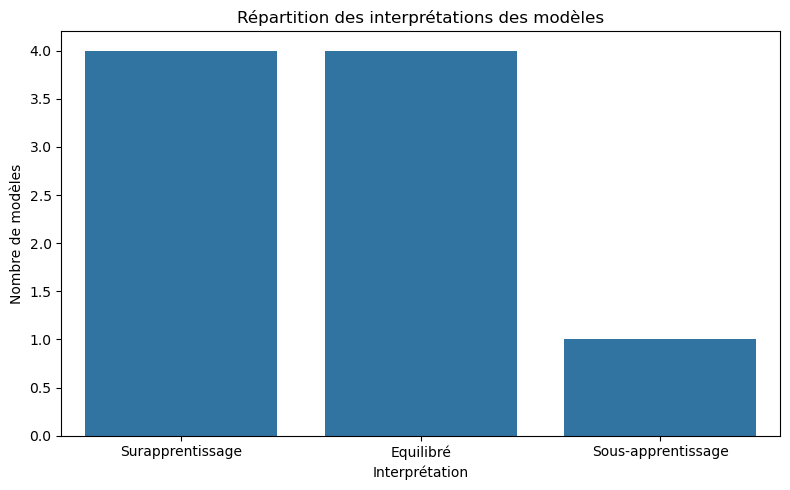

d'après le résumé il y a 4 modèles équilibrés


In [58]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_resume,x="interpretation")
plt.title("Répartition des interprétations des modèles")
plt.xlabel("Interprétation")
plt.ylabel("Nombre de modèles")

plt.tight_layout()
plt.show()


equilibre=df_resume["interpretation"].value_counts()

print(f"d'après le résumé il y a {equilibre.get('Equilibré', 0)} modèles équilibrés")


# Remarques
Nous avons déjà une idée des modèles susceptibles d'être utilisés pour la prédiction, mais il s'agit d'une vue globale : elle regroupe les résultats indépendamment de la taille ou du nombre d'échantillons.  
Une analyse approfondie par taille d'image est nécessaire pour déterminer si la taille influence significativement le gap train/test et s'il existe une évolution des performances selon les tailles.


# Analyse détaillée par rapport à la taille

In [60]:
gap = df["score_train"] - df["score_test"]
dfdf=df.set_index(["taille"]).copy()
dfdf["gap"]=dfdf["score_train"] - dfdf["score_test"]

dfdf["interpretation"] = "Equilibré"
dfdf.loc[(dfdf["score_train"] > dfdf["score_test"]) & (dfdf["gap"] > 0.27),"interpretation"] = "Sur-apprentissage"
dfdf.loc[(dfdf["score_train"] < 0.8) & (dfdf["score_test"] < 0.8),"interpretation"] = "Sous-apprentissage"


# on filtre par rapport au modele l'interpretation
resume=dfdf.loc[(dfdf["interpretation"] == "Equilibré") ,::]
resume.describe()

,sample,score_train,score_test,Temps(s),gap
count,79.000000,79.000000,79.000000,79.000000,79.000000
mean,5676.658228,0.947658,0.740009,599.689620,0.207649
std,2377.747646,0.051439,0.026979,1307.470188,0.044671
min,1664.000000,0.841900,0.654700,0.780000,0.109100
25%,4664.000000,0.909350,0.726450,23.355000,0.168650
50%,6664.000000,0.929700,0.738700,67.590000,0.219800
75%,8664.000000,1.000000,0.761800,567.140000,0.243100
max,8664.000000,1.000000,0.795900,8674.880000,0.269200


Nous avons filtré les modèles considérés comme équilibrés.
D’après le describe, on observe des moyennes de scores d’environ :
 - Train : ~0.947
 - Test : ~0.740

À première vue, la colonne score_train semble correcte, mais dans score_test, on remarque une valeur minimale de 0.6547, relativement faible pour un modèle classé comme équilibré.Cela suggère que certains modèles avec de faibles performances test ont été compensés (tirés vers le haut) par d’autres modèles ayant de très bonnes performances, ce qui donne une moyenne globale trompeuse.

De plus, en filtrant les modèles équilibrés :

 - Nous sommes passés d’environ 25% à 50% du jeu de données avec un score train supérieur à 90%.
 - Autrement dit, presque la moitié des modèles ont un score train très élevé, ce qui peut masquer les modèles ayant un score test faible.

La prochaine étape sera donc de filtrer également les modèles équilibrés mais avec un score test insuffisant, afin d’obtenir une vision réellement fiable des modèles utilisables pour la prédiction.

# Ajustement du filtre pour le score de test

In [68]:
# Ajustement du code précédent pour filtrer les modèles équilibrés mais faibles
# Équilibré faible (gap faible mais score de test trop bas)
dfdf.loc[(dfdf["gap"] < 0.27) & (dfdf["score_test"] <= 0.7),"interpretation" ]= "Equilibré mais faible"

# Équilibré solide (vraiment bon)
dfdf.loc[(dfdf["gap"] < 0.27) & (dfdf["score_test"] > 0.7),"interpretation"] = "Equilibré solide"

# Filtrage selon l'interprétation du modèle
resume=dfdf.loc[(dfdf["interpretation"].str.contains("Equilibré")) ,:]

# Description des modèles équilibrés solides
resume[resume["interpretation"] == "Equilibré solide"].describe()

,sample,score_train,score_test,Temps(s),gap
count,72.000000,72.000000,72.000000,72.000000,72.000000
mean,5747.333333,0.953343,0.745192,536.828333,0.208151
std,2311.940835,0.049750,0.021664,1236.419655,0.045600
min,1664.000000,0.844100,0.704100,0.780000,0.109100
25%,4664.000000,0.917725,0.731175,21.340000,0.168775
50%,6664.000000,0.957200,0.741000,60.970000,0.223950
75%,8664.000000,1.000000,0.763825,521.890000,0.244100
max,8664.000000,1.000000,0.795900,8674.880000,0.269200


Un nouvel ajustement a été appliqué afin de mieux isoler les modèles équilibrés mais présentant un score_test trop faible.
Désormais :

 - les modèles ayant score_test < 0.7 et gap < 0.27 sont étiquetés comme “Équilibré mais faible” ;
 - les modèles ayant score_test > 0.7 et gap < 0.27 sont considérés comme “Équilibré solide”.

Après ce filtrage, on observe une amélioration notable dans la distribution des modèles solides.
En particulier, pour la colonne score_test :

 - la moyenne est passée de 0.740 à 0.745 ;
 - la valeur minimale est passée de 0.6547 à 0.7041.

Cela montre que l’ajustement du filtre permet d’exclure les modèles équilibrés mais peu fiables, et de conserver uniquement ceux dont les performances test sont réellement solides.

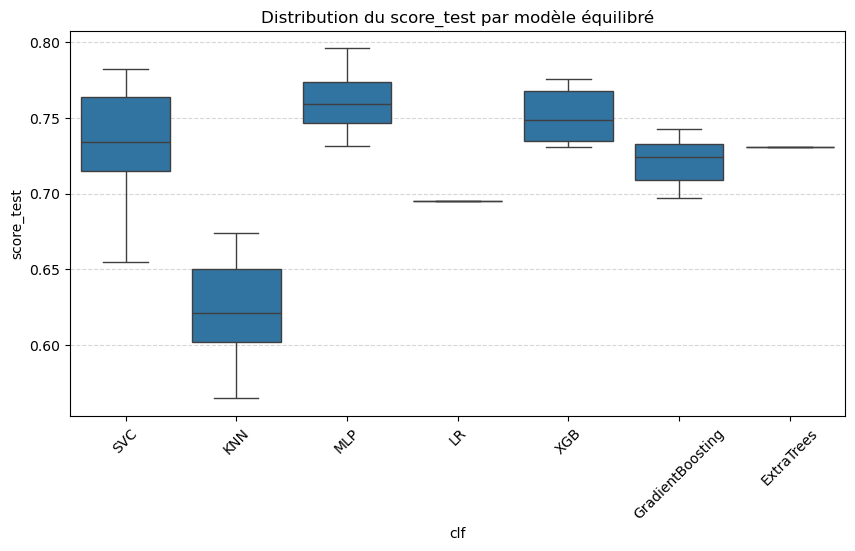

In [64]:
plt.figure(figsize=(10,5))

sns.boxplot(data=resume, x="clf", y="score_test")
plt.title("Distribution du score_test par modèle équilibré")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


On peut déjà identifier certains modèles prometteurs pour notre projet COVID, comme MLP ou XGB,
qui présentent de bonnes performances test et un gap raisonnable.

En revanche, KNN semble moins adapté. En effet, KNN prédit la classe d’un échantillon en se basant
sur ses plus proches voisins dans l’espace des features.
Pour résumer : les pixels ne sont pas indépendants ; leur valeur n’a de sens que par rapport à leurs voisins.
KNN ignore cette relation spatiale, d’où ses performances médiocres sur les images brutes.

---

### Analyse détaillée des scores train/test par taille d'image pour les modèles équilibrés solides


Cette cellule regroupe les informations des modèles "Équilibré solide" par taille d'image.
##### Pour chaque taille, on calcule :
 - la moyenne des scores d'entraînement (score_train)
 - la moyenne des scores de test (score_test)
 - la moyenne du temps d'entraînement (Temps(s))
 - la moyenne du gap train/test (gap)
 - les modèles (clf) utilisés
 
Cette vue permet de vérifier si la taille des images influence les performances et la stabilité
des modèles, et d’identifier les tailles les plus adaptées pour notre projet COVID.



In [65]:
detail=resume.reset_index().copy()
detail[detail["interpretation"] == "Equilibré solide"].groupby("taille").agg({"score_train":"mean",
                                                                                "score_test":"mean",
                                                                                "Temps(s)":"mean",
                                                                                "gap":"mean",
                                                                                "clf":"unique"})



,score_train,score_test,Temps(s),gap,clf
taille,,,,,
64,0.947600,0.740912,183.071875,0.206688,"[SVC, MLP, GradientBoosting, XGB, ExtraTrees]"
128,0.956883,0.752767,285.245000,0.204117,"[SVC, MLP, XGB, GradientBoosting]"
176,0.952859,0.748106,562.468824,0.204753,"[SVC, MLP, GradientBoosting, XGB]"
224,0.953550,0.743914,1291.097857,0.209636,"[SVC, MLP, XGB, GradientBoosting]"
299,0.958129,0.730971,421.534286,0.227157,"[SVC, MLP, XGB]"


Par la suite, nous pouvons déterminer quels modèles privilégier pour notre projet.
On observe que le score train augmente légèrement avec la taille des images, mais que le gap train/test augmente également, et que le temps de calcul devient plus long.

Pour les petites tailles (64 et 128), nous avons de bons scores, un gap faible et un temps de calcul réduit, ce qui les rend attractives pour un premier choix de modèles.

Ensuite, pour chaque modèle, il sera intéressant de vérifier si leur moyenne et écart-type sont proches de la moyenne globale par taille. Selon ces observations, nous pourrons sélectionner le ou les modèles à optimiser pour les phases suivantes du projet.

---

# Application d'un seuil pour modele stable 

Dans cette étape, nous filtrons les modèles “Équilibré solide” pour ne conserver que ceux dont les performances sont proches de la moyenne de leur groupe (taille + classifieur).

 - Nous avons calculé la moyenne et l’écart-type du score train et test pour chaque combinaison (taille, clf).
 - Pour chaque modèle, nous avons ensuite calculé la différence entre son score et la moyenne correspondante (diff_mean_train et diff_mean_test).
 - Enfin, nous appliquons un seuil de 0.02 sur ces écarts : seuls les modèles dont l’écart absolu est ≤ 0.02 pour les deux scores sont conservés.

Cette méthode permet de sélectionner les modèles stables, dont les performances sont représentatives et peu dispersées, ce qui est crucial pour l’optimisation et le choix final des modèles pour notre projet COVID.

In [69]:
final=resume[resume["interpretation"] == "Equilibré solide"].copy()

# Calcul des moyennes et écarts-types du score train et test pour chaque combinaison (taille, classifieur)
moyennes=final.groupby(["taille","clf"]).agg({"score_train":["mean","std"],"score_test":["mean","std"]}).reset_index()

# Renommage des colonnes pour plus de lisibilité
moyennes.columns = ["taille","clf","mean_train","std_train","mean_test","std_test"]
final=final.merge(moyennes, on=["taille", "clf"], how="left")


# Calcul de la différence entre le score du modèle et la moyenne correspondante
final["diff_mean_train"] = final["score_train"] - final["mean_train"]
final["diff_mean_test"] = final["score_test"] - final["mean_test"]

# Application d'un seuil pour ne conserver que les modèles stables
# Seuil d'écart considéré "important" : 0.02
seuil = 0.02

# Filtrage des modèles dont l'écart absolu dépasse le seuil pour train ou test
final = final[(final['diff_mean_train'].abs() <= seuil) & (final['diff_mean_test'].abs() <= seuil)]
final.head()

,taille,Type,sample,clf,score_train,score_test,Temps(s),gap,interpretation,mean_train,std_train,mean_test,std_test,diff_mean_train,diff_mean_test
3,64,Classique,2664,SVC,0.9283,0.7322,4.45,0.1961,Equilibré solide,0.92174,0.006170,0.74800,0.020788,0.00656,-0.01580
4,128,Classique,2664,SVC,0.9302,0.7392,6.95,0.1910,Equilibré solide,0.92580,0.004224,0.75264,0.025497,0.00440,-0.01344
5,128,Classique,2664,MLP,1.0000,0.7465,6.18,0.2535,Equilibré solide,1.00000,0.000000,0.76500,0.015066,0.00000,-0.01850
6,176,Classique,2664,SVC,0.9249,0.7299,99.85,0.1950,Equilibré solide,0.92044,0.003013,0.74680,0.029752,0.00446,-0.01690
9,64,Classique,4664,SVC,0.9209,0.7525,12.01,0.1684,Equilibré solide,0.92174,0.006170,0.74800,0.020788,-0.00084,0.00450


# Choix des modèles pour la prédiction

Comme nous l'avons vu précédemment, nous avons appliqué un seuil afin de ne conserver que les modèles stables.
Pour déterminer quels modèles restent stables selon la taille des images et l’ensemble des samples testés, nous affichons un graphique par classifieur.

Chaque graphique montre :

 - l’évolution du score moyen train et test en fonction du nombre de samples,
 - les bandes ± écart-type pour visualiser la dispersion des scores,
 - les points de données pour chaque taille d’image.

À partir de ces graphiques, nous pourrons identifier les modèles les plus stables et performants pour notre projet COVID et décider lesquels retenir pour la prédiction finale.

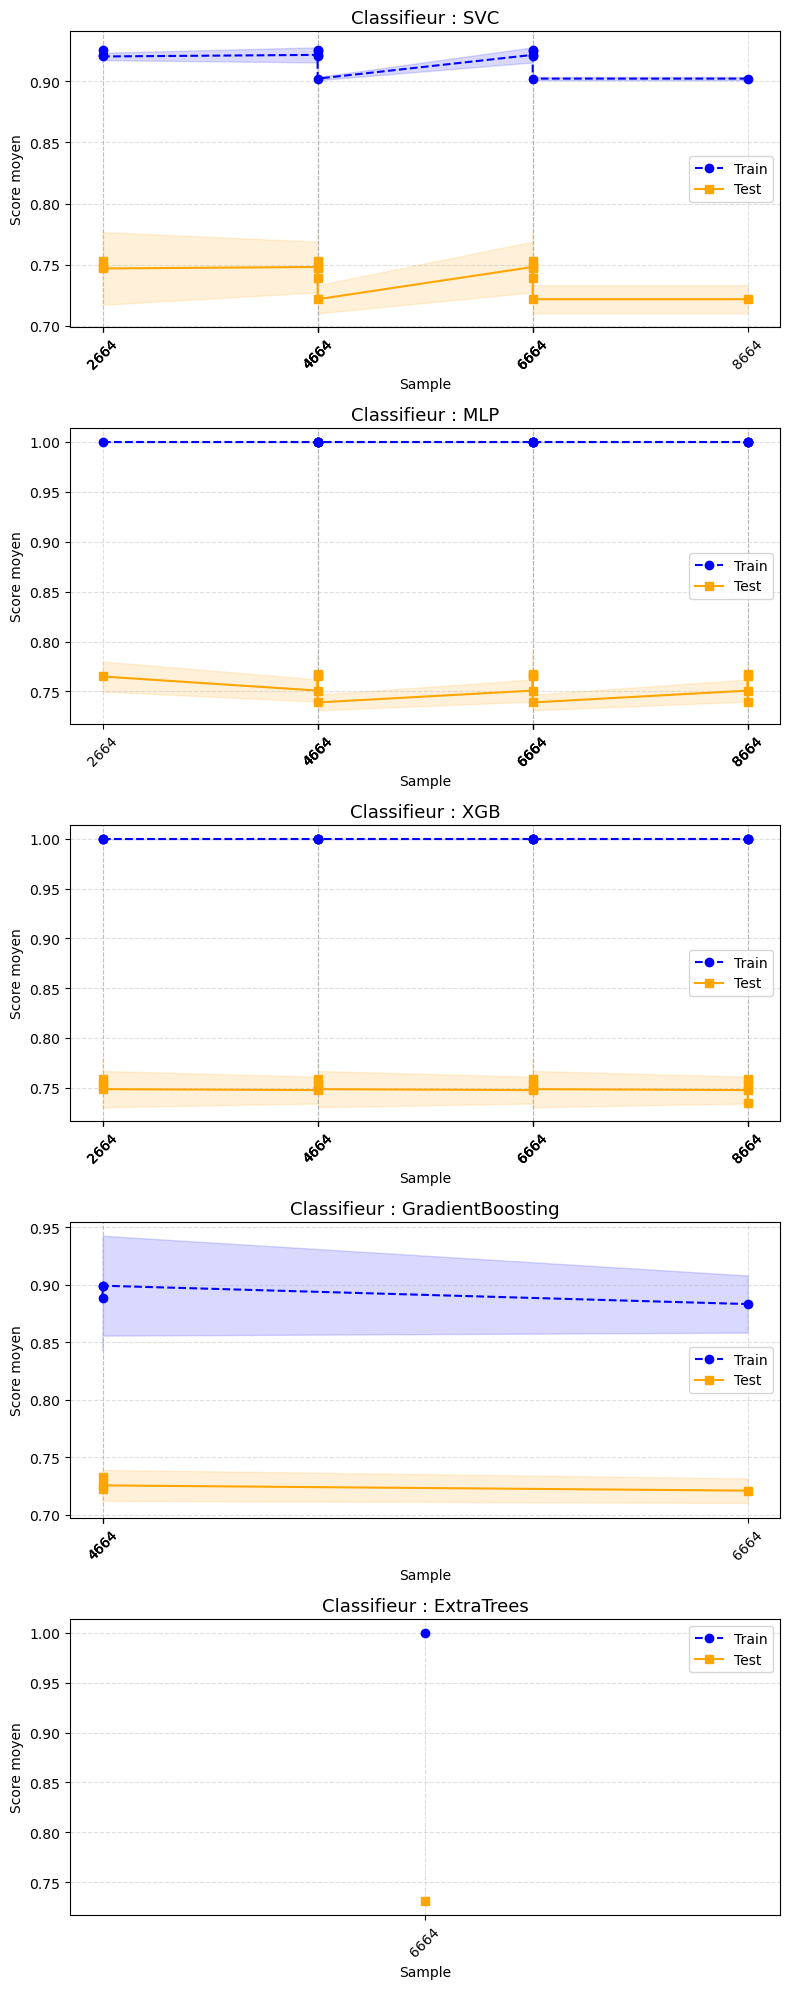

In [70]:
# Liste des classifieurs uniques dans le dataset final
clfs = final["clf"].unique()
n = len(clfs)

# Création de subplots : un graphique par modèle
fig, axes = plt.subplots(n, 1, figsize=(8, 4*n), sharex=False)

# Boucle pour tracer les scores de chaque modèle
for ax, clf in zip(axes, clfs):
    subset = final[final["clf"] == clf]

    # Tracer l'évolution du score moyen Train et Test
    ax.plot(subset["sample"], subset["mean_train"], marker='o', linestyle='--', label="Train", color='blue')
    ax.plot(subset["sample"], subset["mean_test"], marker='s', linestyle='-', label="Test", color='orange')

    # Titres et labels
    ax.set_title(f"Classifieur : {clf}", fontsize=13)
    ax.set_xlabel("Sample")
    ax.set_ylabel("Score moyen")
    
    # Affiche les valeurs exactes des samples sur l'axe X
    ax.set_xticks(subset["sample"])
    ax.set_xticklabels(subset["sample"].astype(str), rotation=45)

    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.4)

    # Bandes ± écart-type pour visualiser la dispersion des scores
    ax.fill_between(
        subset["sample"],
        subset["mean_train"] - subset["std_train"],
        subset["mean_train"] + subset["std_train"],
        color='blue', alpha=0.15, label="Train ± std"
    )
    
    ax.fill_between(
        subset["sample"],
        subset["mean_test"] - subset["std_test"],
        subset["mean_test"] + subset["std_test"],
        color='orange', alpha=0.15, label="Test ± std"
    )
    
# Ajustement de la mise en page pour éviter le chevauchement
plt.tight_layout()
plt.show()


D’après les graphes, nous allons choisir XGB avec une taille de 128, car il présente des scores homogènes et une variation minimale par rapport au nombre d’images (sample).

Comme observé dans la section “Analyse détaillée des scores train/test par taille d'image” :

 - Plus la taille des images augmente, plus le temps de calcul et le gap train/test augmentent légèrement.
 - À partir de la taille 176, le temps de calcul double quasiment, mais les scores restent stables.

Pour le choix final, nous retiendrons donc XGB qui présente des variations tres négligeables entre tailles comparé aux autres modèles.

Les autres modèles présentent des limitations :

 - ExtraTrees et GradientBoosting : pas assez de données pour certaines tailles.
 - SVC : scores très instables selon la taille des images.